In [3]:
from os import environ
from tempfile import mkdtemp

input_folder = environ.get('CROSSCOMPUTE_INPUT_FOLDER', 'tests/standard/input')
output_folder = environ.get('CROSSCOMPUTE_OUTPUT_FOLDER', mkdtemp())
log_folder = environ.get('CROSSCOMPUTE_LOG_FOLDER', mkdtemp())
debug_folder = environ.get('CROSSCOMPUTE_DEBUG_FOLDER', mkdtemp())

In [4]:
from os.path import join

log_file = open(join(log_folder, 'log.txt'), 'wt')

In [5]:
import geotable

region_path = join(input_folder, 'region.geojson')
region_geotable = geotable.load(region_path)
try:
    region_proj4 = region_geotable['geometry_proj4'][0]
except (KeyError, IndexError):
    log_file.write('No region specified. Please specify at least one region.')
region_geotable

,geometry_object,geometry_layer,geometry_proj4
0,"POLYGON ((0 0, 10 0, 10 10, 0 10, 0 0))",region,+proj=longlat +datum=WGS84 +no_defs


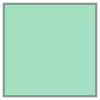

In [6]:
from shapely.ops import cascaded_union

region_geometry = cascaded_union(region_geotable.geometries)
region_geometry

In [7]:
minimum_x, minimum_y, maximum_x, maximum_y = region_geometry.bounds
minimum_x, minimum_y, maximum_x, maximum_y

(0.0, 0.0, 10.0, 10.0)

In [8]:
import json

settings = json.load(open(join(input_folder, 'settings.json')))
settings

{'count': 100}

In [9]:
point_count = settings['count']
point_count

100

In [13]:
import random
from shapely.geometry import Point

def make_random_points(region_geometry, target_count):
    # https://crosscompute.com/n/kRpuoRdCNNRP7bmeOxQE9EOw8QNPvl5j
    points = []
    # while True:
    count = len(points)
    # if count >= target_count:
        # break
    # Generate random points inside bounds
    random_points = [Point(
        random.uniform(minimum_x, maximum_x),
        random.uniform(minimum_y, maximum_y),
    ) for _ in range(target_count)]
    # Retain points inside region
    random_point_collection = cascaded_union(random_points + points)
    points = list(random_point_collection.intersection(region_geometry))
    # Trim if there are too many
    return points[:target_count]

points = make_random_points(region_geometry, point_count)

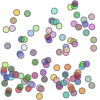

In [14]:
from geotable import ColorfulGeometryCollection
ColorfulGeometryCollection(points)

In [15]:
points_geotable = geotable.GeoTable()
points_geotable['geometry_object'] = points
points_geotable['geometry_proj4'] = region_proj4
points_geotable.save_geojson(join(output_folder, 'points.geojson'))

'/tmp/tmpl8g0h52x/points.geojson'